# Veriyi anlamak

In [ ]:
import numpy as pd
import datetime as dt
import tensorflow as tf
import matplotlib.pyplot as plt

# Model metriklerini ve veriyi scale edebilmemiz için kullanılacak olan kütüphaneler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Model için kullanılacak olan kütüphaneler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Uyarıları kapatmak için kullanılmaktadır.
import warnings
warnings.filterwarnings("ignore")

# Tensorflow uyarı engelleme
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Veri setinin yüklenmesi ve genel resmin incelenmesi

In [ ]:
import pandas as pd
df = pd.read_csv("AirPassengers.csv")
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [ ]:
df.columns

Index(['Month', '#Passengers'], dtype='object')

In [ ]:
df.columns = ["Month", "Passangers"]

In [ ]:
df.head()

,Month,Passangers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [ ]:
df.tail()

,Month,Passangers
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390
143,1960-12,432


In [ ]:
df.shape

(144, 2)

In [ ]:
df.dtypes

,0
Month,object
Passangers,int64


In [ ]:
df.isnull().sum()

,0
Month,0
Passangers,0


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Passangers,144.0,280.298611,119.966317,104.0,180.0,265.5,360.5,622.0


# Veriyi hazırlamak (Data Preparation)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       144 non-null    object
 1   Passangers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [ ]:
df["Month"] = pd.to_datetime(df["Month"])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       144 non-null    datetime64[ns]
 1   Passangers  144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB


In [ ]:
print("Minimum Tarih:", df["Month"].min())
print("Maximum Tarih:", df["Month"].max())

Minimum Tarih: 1949-01-01 00:00:00
Maximum Tarih: 1960-12-01 00:00:00


In [ ]:
df.index = df['Month']

In [ ]:
df.head()

,Month,Passangers
Month,,
1949-01-01,1949-01-01,112
1949-02-01,1949-02-01,118
1949-03-01,1949-03-01,132
1949-04-01,1949-04-01,129
1949-05-01,1949-05-01,121


In [ ]:
df.drop("Month", axis=1, inplace=True)

In [ ]:
df.head()

,Passangers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [ ]:
result_df = df.copy()

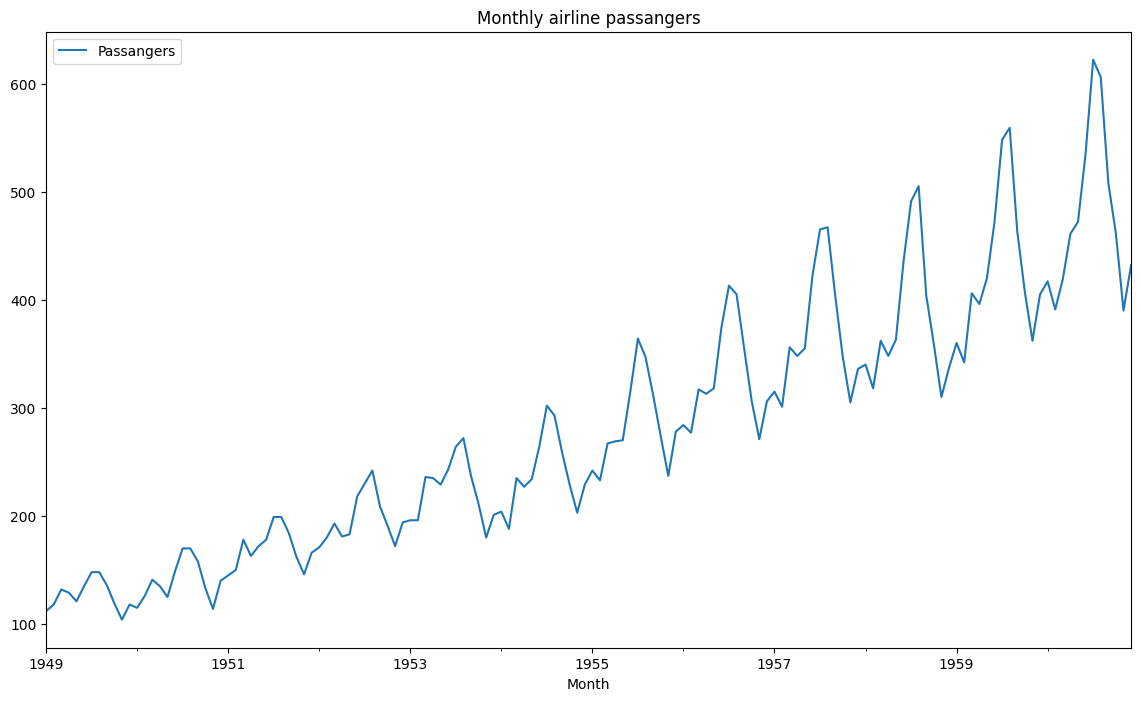

In [ ]:
df.plot(figsize = (14,8),
        title = "Monthly airline passangers");

In [ ]:
data = df["Passangers"].values

In [ ]:
data[0:5]

array([112, 118, 132, 129, 121])

In [ ]:
type(data[0:5])

numpy.ndarray

In [ ]:
type(data[0])

numpy.int64

In [ ]:
data = data.astype("float32")

In [ ]:
type(data[0])

numpy.float32

In [ ]:
data.shape

(144,)

In [ ]:
data = data.reshape(-1,1)

In [ ]:
data.shape

(144, 1)

# Model eğitimi

In [ ]:
# Veri setimiz zaman serisi formatında olduğu için rastgele veriyi test train diye ayırırsak sağlıklı olmaz
# Bu yüzden zaman serisi modellerinde veriyi kendimizin ayırması daha sağlıklı oluyor

In [ ]:
def split_data(dataframe, test_size):
  position = int(round(len(dataframe) * (1-test_size))) # Veri seti boyutundan mesela test size % 33 olsun onu çıkartıyoruz
  train = dataframe[:position]
  test = dataframe[position:]
  return train, test, position

In [ ]:
train, test, position = split_data(data, 0.33)

In [ ]:
print(train.shape, test.shape)

(96, 1) (48, 1)


In [ ]:
# VERİLERLE ÇALIŞIRKEN VERİLERİ 0-1 ARASI DÖNÜŞTÜRMEYİ ALIŞKANLIK HALE GETİR

In [ ]:
scaler_train = MinMaxScaler(feature_range = (0,1))

In [ ]:
train = scaler_train.fit_transform(train)

In [ ]:
scaler_test = MinMaxScaler(feature_range = (0,1))

In [ ]:
test = scaler_test.fit_transform(test)

In [ ]:
# Traini ayrı testi ayrı scale etmek her zaman daha iyidir. Toplu scale etme

In [ ]:
train[0:5]

array([[0.02588999],
       [0.04530746],
       [0.09061491],
       [0.08090615],
       [0.05501619]], dtype=float32)

In [ ]:
test[0:5]

array([[0.04361373],
       [0.        ],
       [0.17133951],
       [0.1464175 ],
       [0.16822433]], dtype=float32)

In [ ]:
# Zaman serilerindeki değerleri etkileyen verileri en çok etkileyen bir önceki adımdır.
# Pazartesi gün ki değeri etkileyen en önemli faktör pazar günü ki değerdir
# Veya bi haftanın değerlerini etkileyen en önemli faktör bir önceki haftadır

# Bu yüzden veri setinde bir tane daha değişken ekleyeceğiz

In [ ]:
def create_features(data, lookback):
  X, Y = [], []
  for i in range(lookback, len(data)):
    X.append(data[i-lookback:i, 0])
    Y.append(data[i, 0])
  return np.array(X), np.array(Y)

  # Bu fonksyon bizim değerlerimizin 1 önceki adımına bak işlemini gerçekleştirecek

In [ ]:
lookback = 1 # 1 adım geriye git demek

In [ ]:
import numpy as np
# Train veri seti
X_train, y_train = create_features(train, lookback)

In [ ]:
# Test veri seti
X_test, y_test = create_features(test, lookback)

In [ ]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(95, 1) (95,) (47, 1) (47,)


In [ ]:
# RNN kullanmak için verleri 3. boyuta evirdik
X_train = np.reshape(X_train, (X_train.shape[0],1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0],1, X_test.shape[1]))
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [ ]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(95, 1, 1) (95, 1) (47, 1, 1) (47, 1)


# Modelleme (modelling)

In [ ]:
model = Sequential()
model.add(SimpleRNN(units = 50,
                    activation = "relu",
                    input_shape = (X_train.shape[1], lookback)))
model.add(Dropout(0.2))
model.add(Dense(1))

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 50)                  │           2,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,651 (10.36 KB)

 Trainable params: 2,651 (10.36 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Optimizasyon ve değerlendirme metriklerinin ayarlanması
model.compile(optimizer = "adam", loss = "mean_squared_error")

In [ ]:
# Aşırı öğrenme önleyici için erken durdurma ve modelimizi hep kaydetme için bunu yapıyoruz
Callbacks = [EarlyStopping(monitor = "val_loss", patience = 3, verbose = 1, mode = "min"),
            ModelCheckpoint(filepath = "mymodel.keras", monitor = "val_loss", mode = "min", # Changed file extension to .keras
                            save_best_only = True, save_weights_only = False, verbose = 1)]

In [ ]:
history = model.fit(x = X_train,
                    y = y_train,
                    epochs = 50,
                    batch_size = 1,
                    validation_data = (X_test, y_test),
                    callbacks = Callbacks,
                    shuffle = False)


Epoch 1/50
80/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0091
Epoch 1: val_loss improved from inf to 0.04150, saving model to mymodel.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0103 - val_loss: 0.0415
Epoch 2/50
71/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0363
Epoch 2: val_loss improved from 0.04150 to 0.02602, saving model to mymodel.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0323 - val_loss: 0.0260
Epoch 3/50
77/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0173
Epoch 3: val_loss improved from 0.02602 to 0.02218, saving model to mymodel.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0171 - val_loss: 0.0222
Epoch 4/50
83/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0091
Epoch 4: val_loss did not improve from 0.02218
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0094 - val_loss: 0.0236
Epoch 5/50
84/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0085
Epoch 5: val_loss improved from 0.02218 to 0.02156, saving model to mymodel.keras
95/95 ━━━━━━

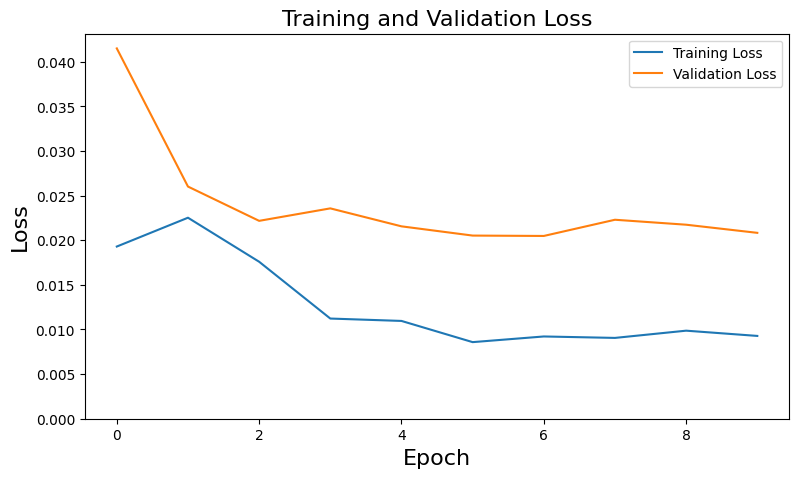

In [ ]:
plt.figure(figsize = (20,5))
plt.subplot(1,2,2)
plt.plot(history.history["loss"], label = "Training Loss")
plt.plot(history.history["val_loss"], label = "Validation Loss")
plt.legend(loc = "upper right")
plt.xlabel("Epoch", fontsize = 16)
plt.ylabel("Loss", fontsize = 16)
plt.ylim([0,max(plt.ylim())])
plt.title("Training and Validation Loss", fontsize = 16)
plt.show()

# Model değerlendirme (Evaluation)


In [ ]:
loss = model.evaluate(X_test, y_test, batch_size = 1)
print("\nTest loss: %.1f%%" % (100.0 * loss))

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0161

Test loss: 2.1%


In [ ]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 222ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


In [ ]:
train_predict = scaler_train.inverse_transform(train_predict)
test_predict = scaler_test.inverse_transform(test_predict)

In [ ]:
y_train = scaler_train.inverse_transform(y_train)
y_test = scaler_test.inverse_transform(y_test)

In [ ]:
# Train veri setine ait RMSE değeri
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))

In [ ]:
# Test veri setine ait RMSE değeri
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))

In [ ]:
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse} ")

Train RMSE: 69787.7890625
Test RMSE: 46.33080291748047 


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Passangers,144.0,280.298611,119.966317,104.0,180.0,265.5,360.5,622.0


In [ ]:
result_df

,Passangers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


In [ ]:
train_prediction_df = result_df[lookback:position]

In [ ]:
train_prediction_df["Predicted"] = train_predict

In [ ]:
train_prediction_df.head()

,Passangers,Predicted
Month,,
1949-02-01,118,126.768227
1949-03-01,132,129.382629
1949-04-01,129,140.245163
1949-05-01,121,137.434570
1949-06-01,135,131.258148


In [ ]:
test_prediction_df = result_df[position+lookback:]
test_prediction_df["Predicted"] = test_predict
test_prediction_df.head()

,Passangers,Predicted
Month,,
1957-02-01,301,327.064117
1957-03-01,356,321.532776
1957-04-01,348,362.929291
1957-05-01,355,355.434448
1957-06-01,422,361.992462


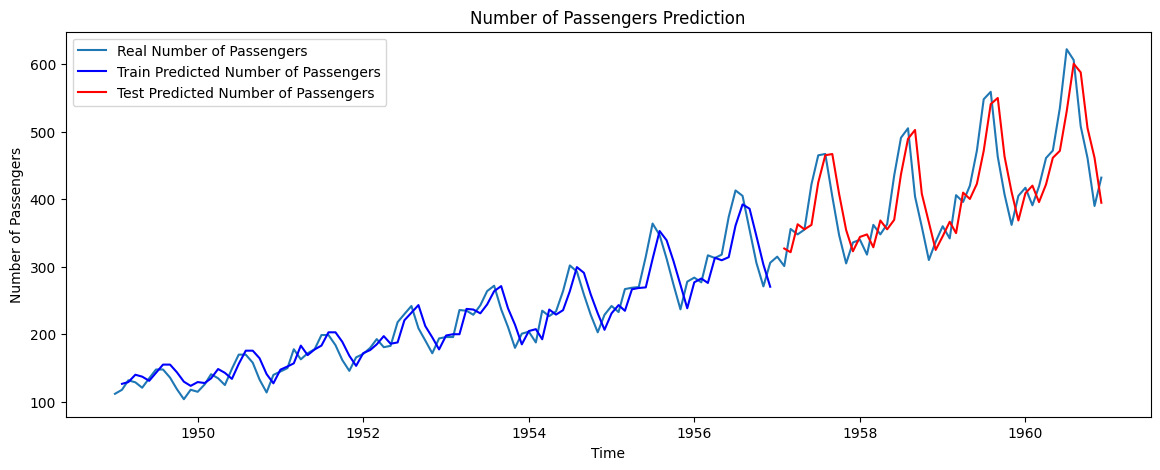

In [ ]:
# Train ve test tahminlerini ayrı ayrı görselleştirme
plt.figure(figsize = (14,5))
plt.plot(result_df, label = "Real Number of Passengers")
plt.plot(train_prediction_df["Predicted"], color = "blue", label = "Train Predicted Number of Passengers")
plt.plot(test_prediction_df["Predicted"], color = "red", label = "Test Predicted Number of Passengers")
plt.title("Number of Passengers Prediction")
plt.xlabel("Time")
plt.ylabel("Number of Passengers")
plt.legend()
plt.show()